In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
command_file_name = "../data/command/japan_command.json"
celeri.create_output_folder()
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

# Calculate non-elastic operators

In [5]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Plot input data

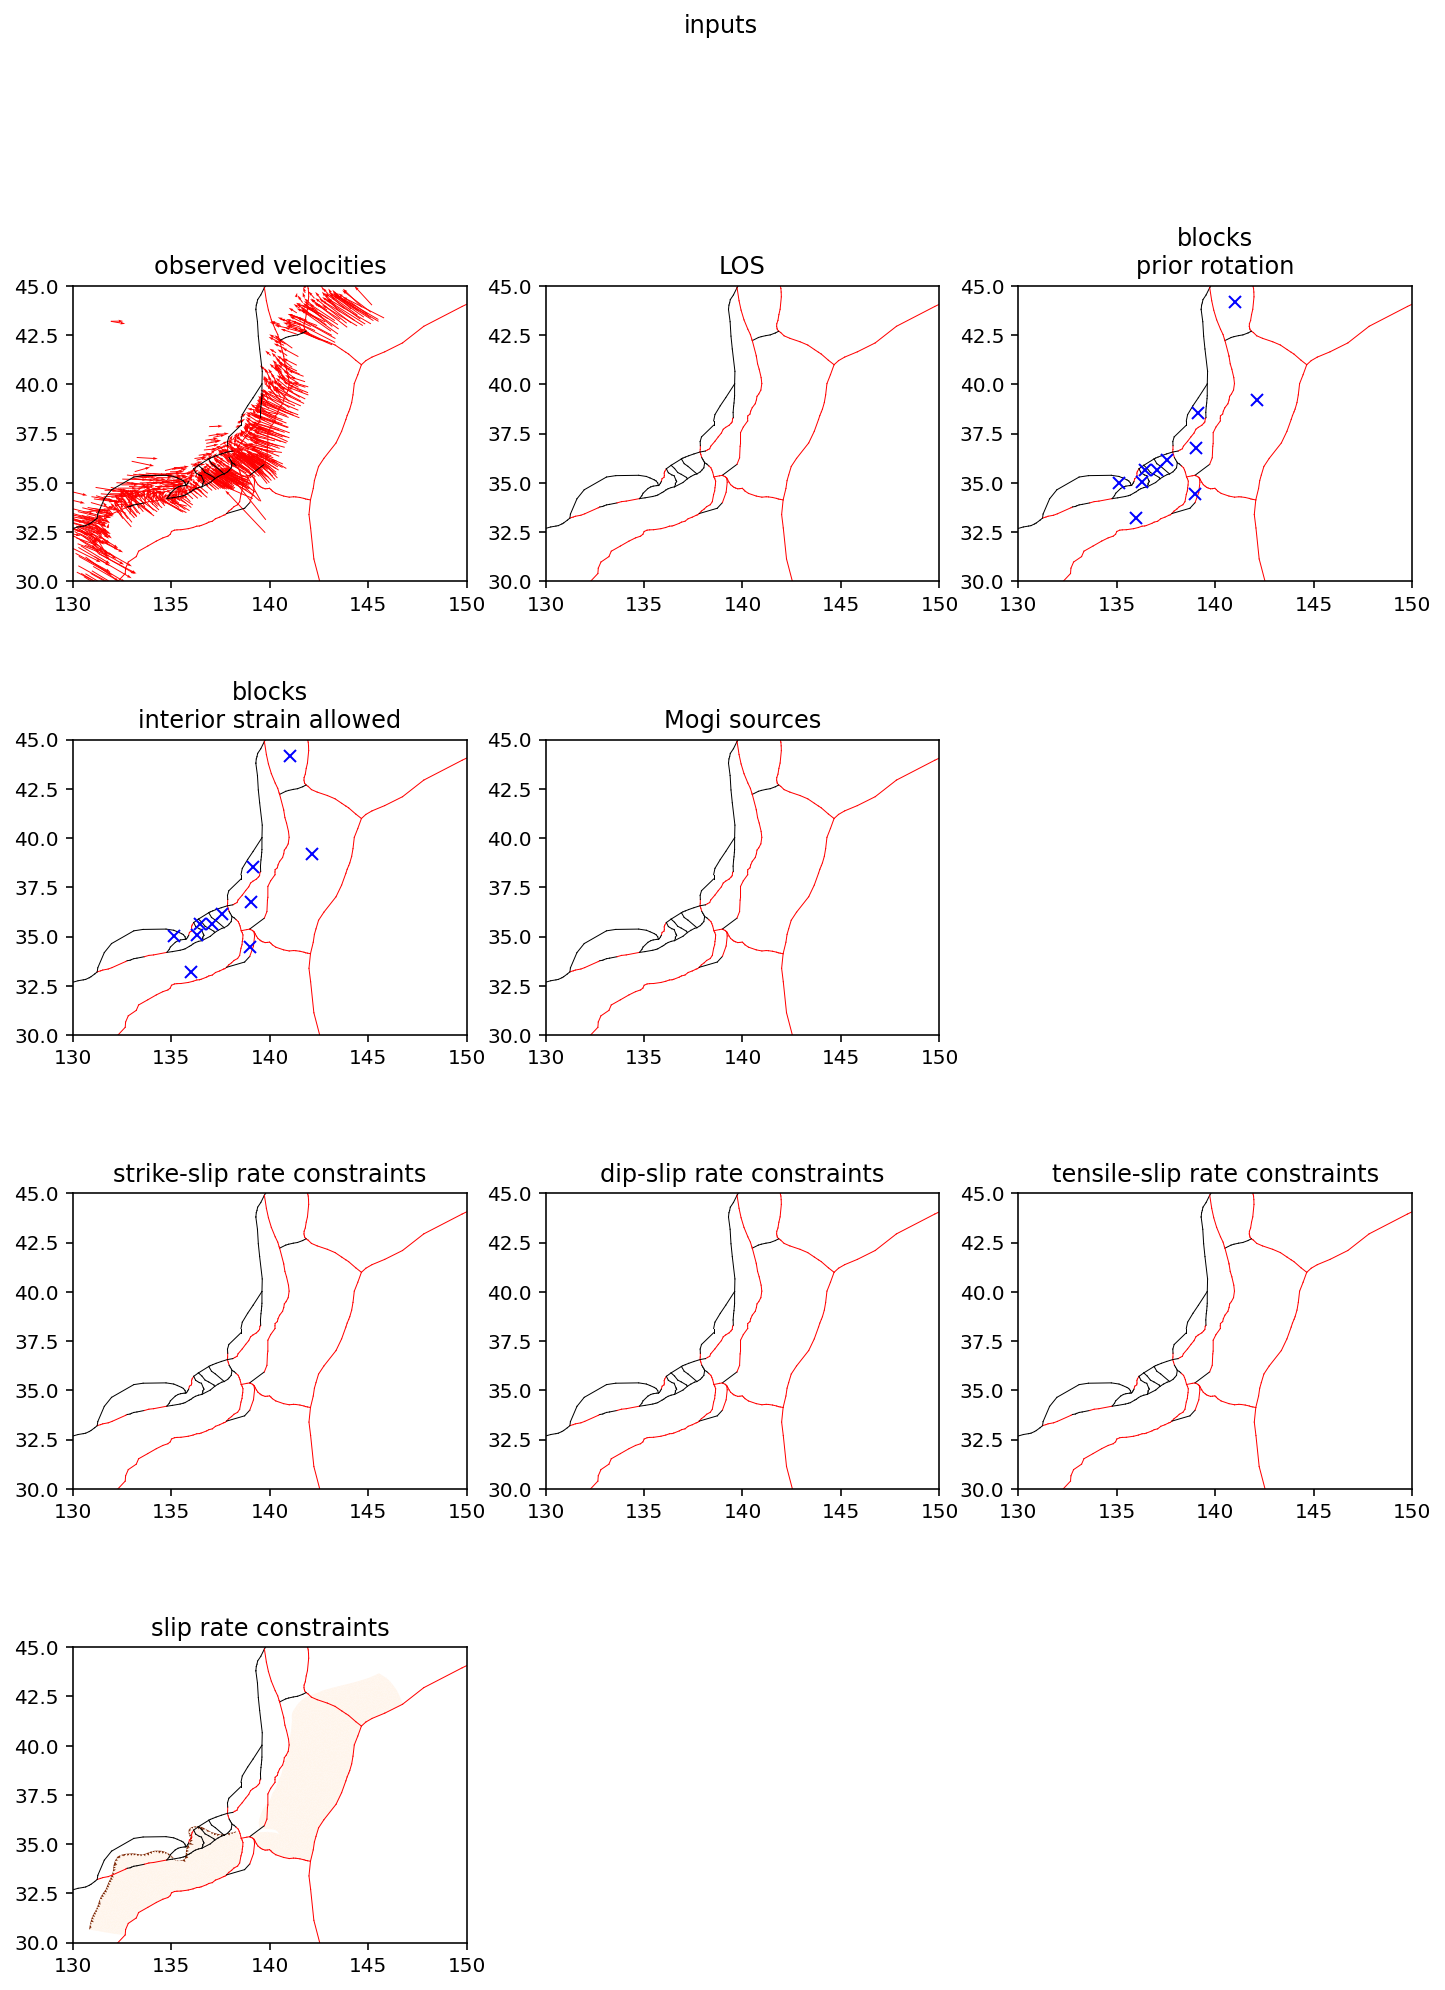

In [6]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [7]:
%time index, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(estimation, station, segment, block)

CPU times: user 3min 13s, sys: 5.05 s, total: 3min 18s
Wall time: 24.3 s


# Plot model summary

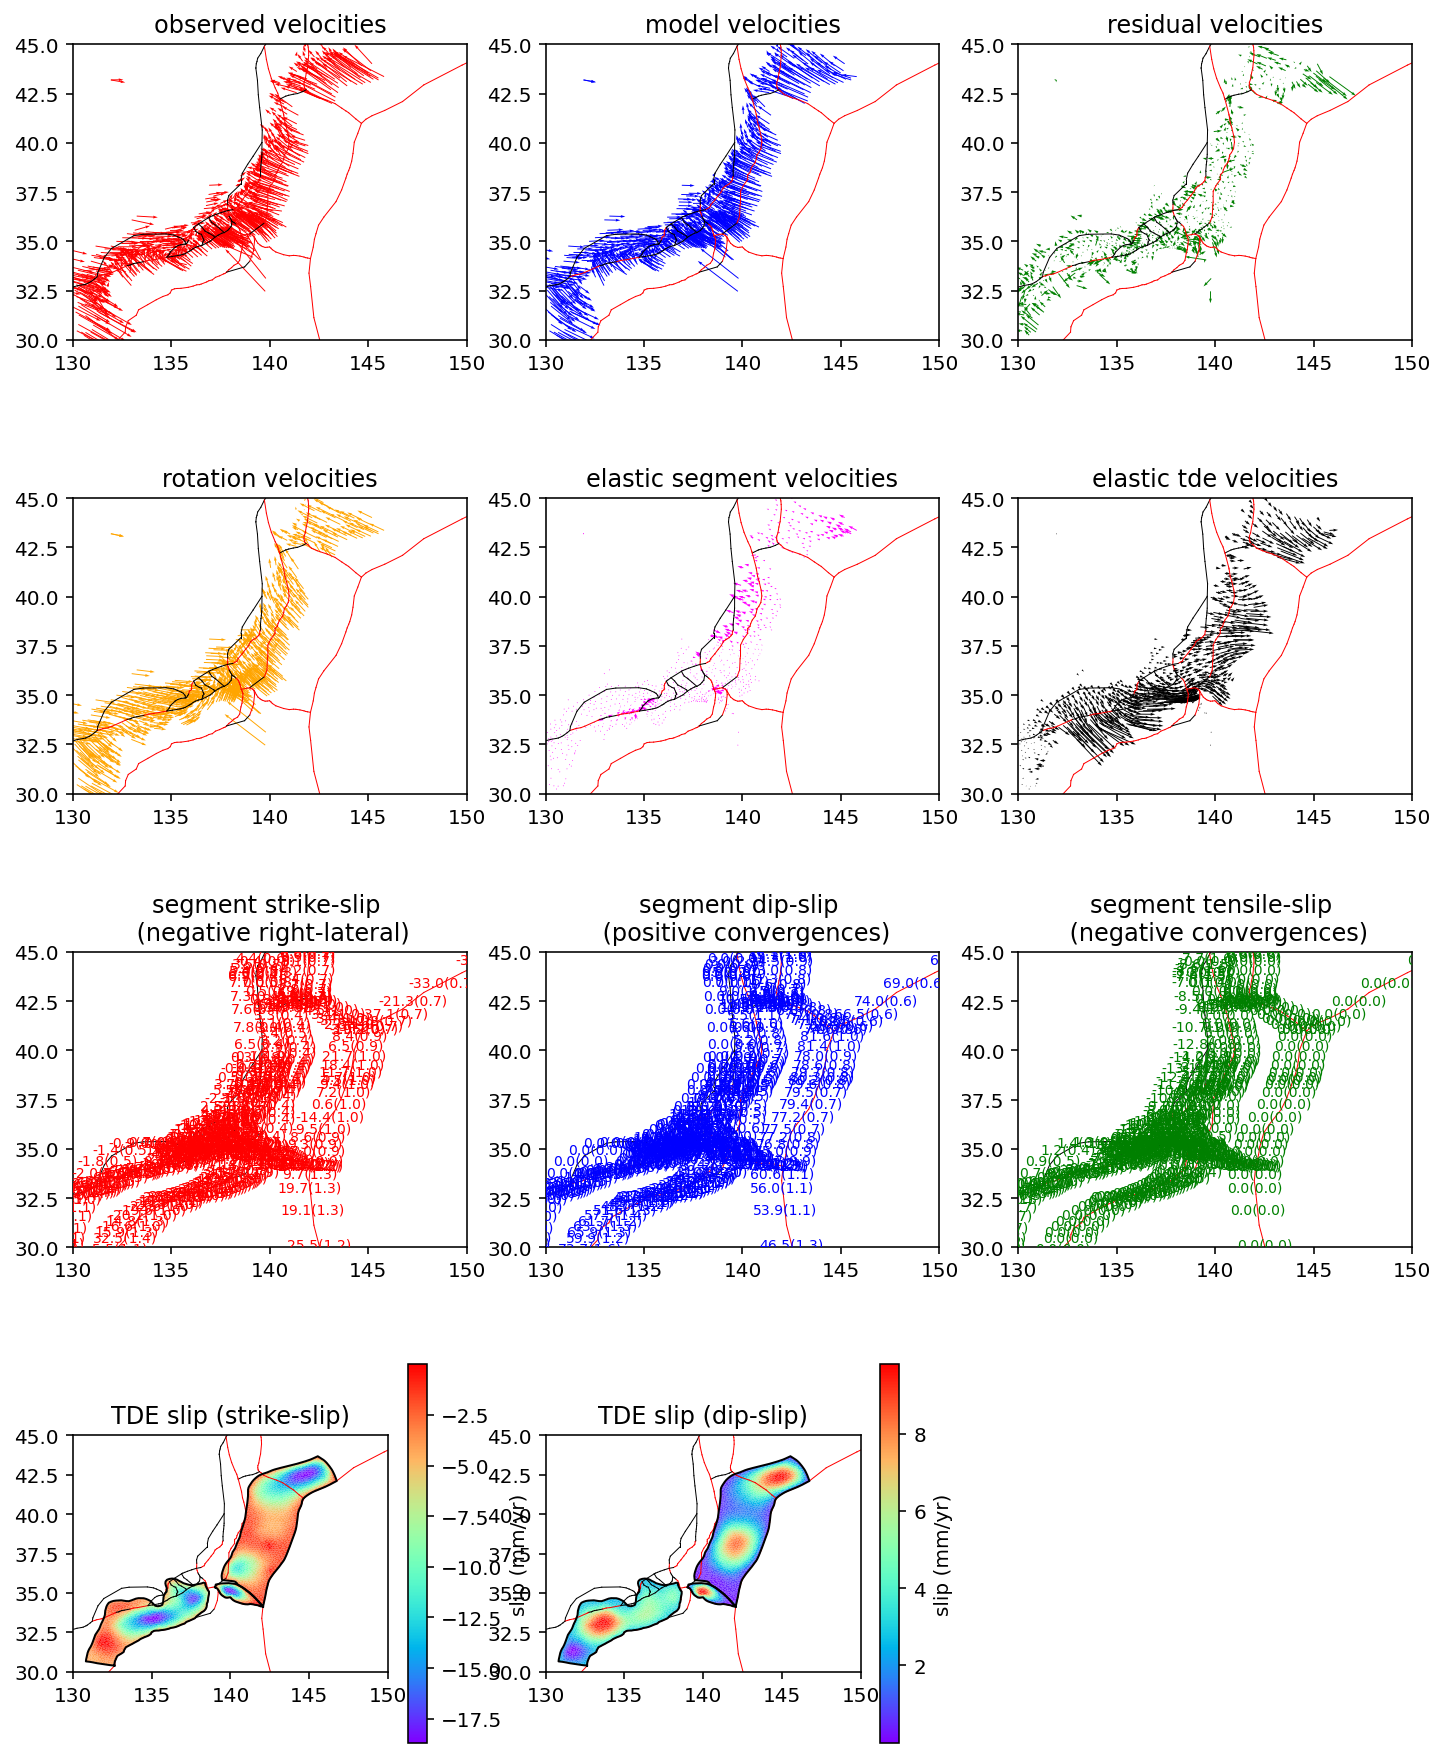

In [8]:
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Short matrix names and normalization for iterative solve experiments

In [9]:
import scipy.sparse
import scipy.sparse.linalg

# Following TBT renaming
W = estimation.weighting_vector
X = estimation.operator
y = estimation.data_vector
Xp = X * np.sqrt(W)[:, None]
yp = y * np.sqrt(W)

# Normalize each column by column norms
col_norms = np.linalg.norm(Xp, axis=0)
XpP = Xp / col_norms[None, :]

# Tolerances for LSMR iterative solver
# As these get smaller the solutions do converge with the dense direct solution
atol = 1e-6
btol = 1e-6

# Dense iterative solve

In [10]:
# Size of dense matrix
print(XpP.nbytes)

# Iterative dense solution
%time lsmr_dense = scipy.sparse.linalg.lsmr(XpP, yp, atol=atol, btol=btol)

# Correct the solution for the col_norms preconditioning.
lsmr_dense_soln = lsmr_dense[0] / col_norms

886198032
CPU times: user 3min 29s, sys: 7.3 s, total: 3min 37s
Wall time: 26.4 s


# Sparse iterative solve

In [11]:
# Size of sparse matrix
print(scipy.sparse.csr_matrix(XpP).data.nbytes)

# Iterative sparse solution
%time lsmr_sparse = scipy.sparse.linalg.lsmr(scipy.sparse.csr_matrix(XpP), yp, atol=atol, btol=btol)

# Correct the solution for the col_norms preconditioning.
lsmr_sparse_soln = lsmr_sparse[0] / col_norms

146346080
CPU times: user 32.2 s, sys: 186 ms, total: 32.4 s
Wall time: 32.5 s


# Hmatrix iterative solve

In [51]:
# Cast all submatrices to sparse and put TDE to velocity matrices in a 3 element list
from scipy.sparse import csr_matrix
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

tde_matrices = []
sparse_tde_smoothing_matrices = []
sparse_tde_slip_rate_constraint_matrices = []
for i in range(len(meshes)):
    tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    smoothing_keep_index = celeri.get_keep_index_12(operators.smoothing_matrix[i].shape[0])
    # tde_matrix = operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
    tde_matrix = operators.tde_to_velocities[i]

    tde_matrices.append(tde_matrix)
    sparse_tde_smoothing = csr_matrix(operators.smoothing_matrix[i][smoothing_keep_index, :][:, smoothing_keep_index])
    sparse_tde_smoothing_matrices.append(sparse_tde_smoothing)
    sparse_tde_slip_rate_constraints = csr_matrix(operators.tde_slip_rate_constraints[i])
    sparse_tde_slip_rate_constraint_matrices.append(sparse_tde_slip_rate_constraints)

# Matrix decomposition for each of the three meshes

In [57]:
from celeri.hmatrix import build_hmatrix_from_mesh_tdes
from celeri.hmatrix import build_hmatrix_from_mesh_tdes_new # Only difference is that you can pass TDE matrix directly

H = []

%time
for i in range(len(meshes)):
    H.append(build_hmatrix_from_mesh_tdes_new(
        meshes[i], 
        station,
        tde_matrices[i],
        1e-2,
        # TBT: min_separation is a ratio of the sizes of the two tree nodes. The
        # exact criteria for two nodes being far enough apart that we are allowed to
        # use an approximate matrix block instead of an exact matrix block is:
        # dist > min_separation * (obs_node.radius + src_node.radius)
        min_separation=1.25,
        min_pts_per_box=20,
    ))


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
(1902, 3) (1902,)
(2621, 3) (2621,)
(231, 3) (231,)


In [35]:
def matvec(v):
    """ BJM: Build matvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns A* u

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: This will depend on how we integrate this into celeri and which
    variable we're talking about. For example, we should stop using X.shape
    entirely because that matrix won't exist in a fully sparse/hmatrix
    implementation!
    One design that I would probably lean towards
    would be something like:
    def build_sparse_hmatrix_linear_operator(operators,...):
        sparse_block_motion_okada_faults = ...
        define_other_precomputable_vars_here = ...

        def matvec(v):
            # use vars from the outer scope
        def rmatvec(v):
            # use vars from the outer scope

        return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)
        


    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    # TBT: It's important to remember to keep the input and output weighting
    # conceptually separate since the "out * np.sqrt(W)" will actually change
    # the solution to the least squares problem whereas the "v / col_norms"
    # preconditioning step is a reversible change to the solution (which is the
    # point since preconditioning should not change the solution!!)
    v_scaled = v / col_norms 

    # BJM: Make storage for output
    out = np.zeros(X.shape[0])

    block_rotations = v_scaled[index.start_block_col : index.end_block_col]
    # okada
    out[index.start_station_row:index.end_station_row] += sparse_block_motion_okada_faults.dot(block_rotations)

    # block motion constraints
    out[index.start_block_constraints_row:index.end_block_constraints_row] += sparse_block_motion_constraints.dot(block_rotations)

    # slip rate constraints
    out[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] += sparse_block_slip_rate_constraints.dot(block_rotations)

    # TODO: Make this work over multiple meshes
    tde_velocities = v_scaled[index.meshes[0].start_tde_col : index.meshes[0].end_tde_col]

    # Insert TDE to velocity matrix
    out[index.start_station_row:index.end_station_row] += H.dot(tde_velocities)

    # TDE smoothing
    out[index.meshes[0].start_tde_smoothing_row:index.meshes[0].end_tde_smoothing_row] += sparse_tde_smoothing.dot(tde_velocities)

    # TDE slip rate constraints
    out[index.meshes[0].start_tde_constraint_row:index.meshes[0].end_tde_constraint_row] += sparse_tde_slip_rate_constraints.dot(tde_velocities)

    # Weight!
    return out * np.sqrt(W)

array([[ 1.12759746e-07,  1.13555882e-07,  8.68594146e-08, ...,
         8.65681181e-08,  1.90480385e-08,  4.82879823e-08],
       [-1.75345996e-07, -8.14757194e-08, -3.72204751e-07, ...,
        -8.56581934e-08, -5.56732391e-08, -5.48251375e-08],
       [ 2.76508138e-07,  5.48554850e-07, -3.03901648e-08, ...,
         3.62448900e-07,  1.57260485e-08,  1.89216841e-07],
       ...,
       [ 1.74369658e-08, -1.55615000e-09, -5.32625432e-08, ...,
         4.75903721e-10, -3.87426757e-09, -2.37113811e-10],
       [ 3.64523288e-08, -1.01292057e-08,  1.59281701e-08, ...,
         1.74616981e-10,  5.73434587e-09,  1.45424294e-09],
       [ 1.35843548e-08, -4.62766376e-10, -7.69385868e-08, ...,
        -6.71901898e-11, -6.90292724e-09, -1.06943734e-09]])

# Compare solutions

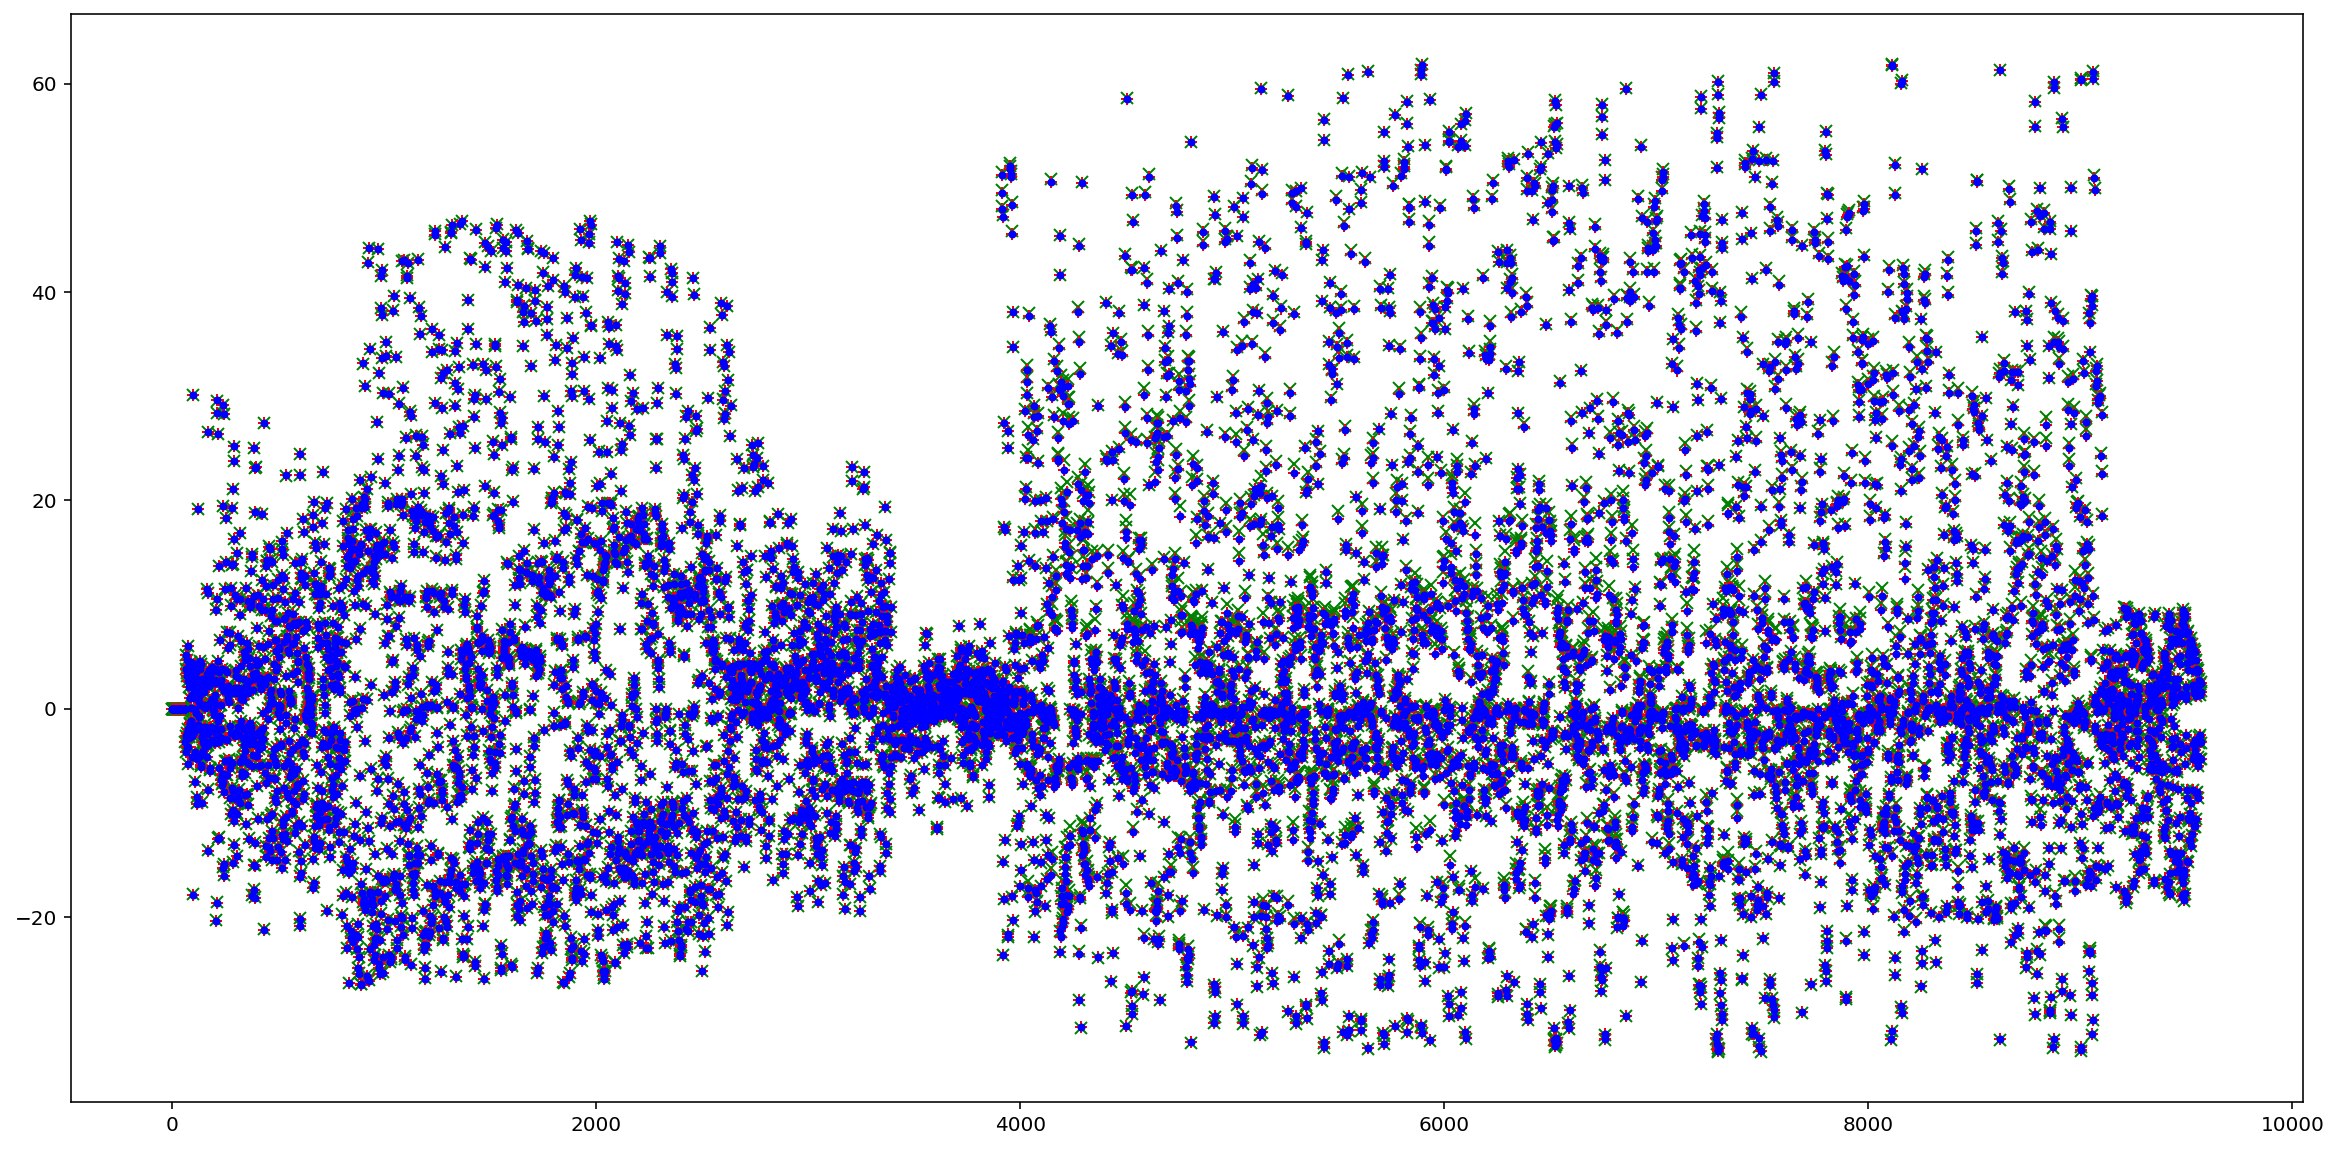

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(estimation.state_vector, "gx")
plt.plot(lsmr_dense_soln, "r+")
plt.plot(lsmr_sparse_soln, "b.")

In [43]:
meshes[0]

{'meshio_object': <meshio mesh object>
   Number of points: 1497
   Number of cells:
     vertex: 481
     line: 418
     triangle: 1902
   Cell data: gmsh:physical, gmsh:geometrical,
 'verts': array([[ 592,  535,  536],
        [ 593,  592,  536],
        [ 593,  536,  537],
        ...,
        [ 868,  867,  787],
        [1493, 1486,  755],
        [1493, 1459, 1486]], dtype=int32),
 'lon1': array([138.502, 138.542, 138.542, ..., 136.742, 133.312, 133.312]),
 'lon2': array([138.587, 138.502, 138.614, ..., 136.612, 133.119, 133.293]),
 'lon3': array([138.614, 138.614, 138.639, ..., 136.507, 133.197, 133.119]),
 'lat1': array([34.7673, 34.8993, 34.8993, ..., 35.7624, 34.2735, 34.2735]),
 'lat2': array([34.6788, 34.7673, 34.8131, ..., 35.8384, 34.2771, 34.3892]),
 'lat3': array([34.8131, 34.8131, 34.948 , ..., 35.7135, 34.1585, 34.2771]),
 'dep1': array([-10.      , -10.      , -10.      , ..., -50.      , -42.712709,
        -42.712709]),
 'dep2': array([  0.      , -10.      ,   0.  

In [47]:
5523 / 3

1841.0